In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# import package
import json
import torch
from pretrain_hierar import arg_parse, generate_reaction_reps, calculate_map
from utils.build_utils import build_retro_iterator, build_model, load_checkpoint
from utils.smiles_utils import clear_map_number
from models.model import ProjectNet
import pandas as pd
import os 
import matplotlib.pyplot as plt
import seaborn as sns
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "8"

### Self-supervised

In [36]:
# load model checkpoint
args = arg_parse(["--data_dir","./data/uspto_1K_TPL_backward/", "--shared_vocab", "--checkpoint", "./result/uspto_1K_TPL_backward/final/selfsup/model_pretrain_best_mAP.pt"])
args.data_file = "retrieval_gallery_set"
gallery_iter, dataset = build_retro_iterator(args, mode="test", sample=False, augment=False, hierar_sampling=False)
args.data_file = "retrieval_query_set"
query_iter, _ = build_retro_iterator(args, mode="test", sample=False, augment=False, hierar_sampling=False)
model = build_model(args, dataset.src_itos, dataset.tgt_itos)
proj = ProjectNet(input_dim=args.d_model*2, hidden_dim=args.d_model, output_dim=args.d_model).to(args.device) 
step, model, proj, optimizer = load_checkpoint(args.checkpoint, model, proj)

Building test data from: ./data/uspto_1K_TPL_backward/
Building test data from: ./data/uspto_1K_TPL_backward/
Loading checkpoint from ./result/uspto_1K_TPL_backward/final/selfsup/model_pretrain_best_mAP.pt


In [37]:
# reaction retrieval
# 1. generate reaction reps
gallery_reps, gallery_labels, gallery_ids = generate_reaction_reps(args, model, proj, gallery_iter)
query_reps, query_labels, query_ids = generate_reaction_reps(args, model, proj, query_iter)
gallery_reps_norm = gallery_reps / torch.norm(gallery_reps, dim=-1).unsqueeze(1) #*[len_train, n_dim] 
query_reps_norm = query_reps / torch.norm(query_reps, dim=-1).unsqueeze(1) #*[len_test, n_dim]

# 2. calculate cosine similarity
pair_cosine_sim = torch.matmul(query_reps_norm, gallery_reps_norm.t())
rank = torch.argsort(1-pair_cosine_sim, axis=1) 
retrieval_idx = rank[:, :5]  #*[num_query, r]
# retrieval_labels = gallery_labels.unsqueeze(0).repeat(retrieval_idx.shape[0], 1).gather(index=retrieval_idx, dim=1) #* [num_query, r]

# 3. calculate metric
for i in range(1, 6):
    mAP = calculate_map(query_feats=query_reps_norm, gallery_feats=gallery_reps_norm, query_labels=query_labels, gallery_labels=gallery_labels, r=i)
    print(f"mAP@{i}={mAP.mean().item()}")

Iteration:   0%|          | 0/625 [00:00<?, ?it/s]

Iteration: 100%|██████████| 188/188 [00:04<00:00, 37.98it/s]


mAP@1=0.24266666173934937
mAP@2=0.21916666626930237
mAP@3=0.20137037336826324
mAP@4=0.18765276670455933
mAP@5=0.17678888142108917


In [9]:
retrieval_idx.shape

torch.Size([1500, 5])

In [10]:
retrieval_gallery_ids = gallery_ids.unsqueeze(0).repeat(retrieval_idx.shape[0], 1).gather(index=retrieval_idx, dim=1) #* [num_query, r]
retrieval_gallery_ids

tensor([[   9, 2520, 2528, 2526, 2151],
        [1486, 4074, 2291, 1187,   94],
        [2999, 1235, 1432,  459,  355],
        ...,
        [3095, 3168, 1324, 4803,  799],
        [ 630, 1384,  144, 2130,  722],
        [2466, 3338, 2468,  343, 2467]], device='cuda:0')

In [11]:
retrieval_df = pd.DataFrame()
retrieval_df["query_ids"] = query_ids.cpu()
retrieval_df["selfsup_gallery_ids"] = retrieval_gallery_ids.cpu().tolist()
retrieval_df

,query_ids,selfsup_gallery_ids
0,0,"[9, 2520, 2528, 2526, 2151]"
1,1,"[1486, 4074, 2291, 1187, 94]"
2,10,"[2999, 1235, 1432, 459, 355]"
3,100,"[337, 336, 844, 4726, 335]"
4,1000,"[3534, 3460, 961, 435, 1416]"
...,...,...
1495,995,"[2150, 2171, 1486, 1028, 3789]"
1496,996,"[511, 312, 2152, 736, 3326]"
1497,997,"[3095, 3168, 1324, 4803, 799]"
1498,998,"[630, 1384, 144, 2130, 722]"


### Supcon-namerxn

In [38]:
# load model checkpoint
args = arg_parse(["--data_dir","./data/uspto_1K_TPL_backward/", "--shared_vocab", "--checkpoint", "./result/uspto_1K_TPL_backward/final/supcon_namerxn/model_pretrain_best_mAP.pt"])
args.data_file = "retrieval_gallery_set"
gallery_iter, dataset = build_retro_iterator(args, mode="test", sample=False, augment=False, hierar_sampling=False)
args.data_file = "retrieval_query_set"
query_iter, _ = build_retro_iterator(args, mode="test", sample=False, augment=False, hierar_sampling=False)
model = build_model(args, dataset.src_itos, dataset.tgt_itos)
proj = ProjectNet(input_dim=args.d_model*2, hidden_dim=args.d_model, output_dim=args.d_model).to(args.device) 
step, model, proj, optimizer = load_checkpoint(args.checkpoint, model, proj)

Building test data from: ./data/uspto_1K_TPL_backward/
Building test data from: ./data/uspto_1K_TPL_backward/
Loading checkpoint from ./result/uspto_1K_TPL_backward/final/supcon_namerxn/model_pretrain_best_mAP.pt


In [39]:
# reaction retrieval
# 1. generate reaction reps
gallery_reps, gallery_labels, gallery_ids = generate_reaction_reps(args, model, proj, gallery_iter)
query_reps, query_labels, query_ids = generate_reaction_reps(args, model, proj, query_iter)
gallery_reps_norm = gallery_reps / torch.norm(gallery_reps, dim=-1).unsqueeze(1) #*[len_train, n_dim] 
query_reps_norm = query_reps / torch.norm(query_reps, dim=-1).unsqueeze(1) #*[len_test, n_dim]

# 2. calculate cosine similarity
pair_cosine_sim = torch.matmul(query_reps_norm, gallery_reps_norm.t())
rank = torch.argsort(1-pair_cosine_sim, axis=1) 
retrieval_idx = rank[:, :5]  #*[num_query, r]

# 3. calculate metric
for i in range(1, 6):
    mAP = calculate_map(query_feats=query_reps_norm, gallery_feats=gallery_reps_norm, query_labels=query_labels, gallery_labels=gallery_labels, r=i)
    print(f"mAP@{i}={mAP.mean().item()}")

Iteration:   0%|          | 0/625 [00:00<?, ?it/s]

Iteration: 100%|██████████| 188/188 [00:04<00:00, 37.66it/s]


mAP@1=0.3440000116825104
mAP@2=0.3141666650772095
mAP@3=0.29418519139289856
mAP@4=0.27776390314102173
mAP@5=0.2650911211967468


In [ ]:
retrieval_gallery_ids = gallery_ids.unsqueeze(0).repeat(retrieval_idx.shape[0], 1).gather(index=retrieval_idx, dim=1) #* [num_query, r]
retrieval_df["supcon_namerxn_gallery_ids"] = retrieval_gallery_ids.cpu().tolist()
retrieval_df

### Supcon-hierar

In [40]:
# load model checkpoint
args = arg_parse(["--data_dir","./data/uspto_1K_TPL_backward/", "--shared_vocab", "--checkpoint", "./result/uspto_1K_TPL_backward/final/supcon_hierar/model_pretrain_best_mAP.pt"])
args.data_file = "retrieval_gallery_set"
gallery_iter, dataset = build_retro_iterator(args, mode="test", sample=False, augment=False, hierar_sampling=False)
args.data_file = "retrieval_query_set"
query_iter, _ = build_retro_iterator(args, mode="test", sample=False, augment=False, hierar_sampling=False)
model = build_model(args, dataset.src_itos, dataset.tgt_itos)
proj = ProjectNet(input_dim=args.d_model*2, hidden_dim=args.d_model, output_dim=args.d_model).to(args.device) 
step, model, proj, optimizer = load_checkpoint(args.checkpoint, model, proj)

Building test data from: ./data/uspto_1K_TPL_backward/
Building test data from: ./data/uspto_1K_TPL_backward/
Loading checkpoint from ./result/uspto_1K_TPL_backward/final/supcon_hierar/model_pretrain_best_mAP.pt


In [41]:
# reaction retrieval
# 1. generate reaction reps
gallery_reps, gallery_labels, gallery_ids = generate_reaction_reps(args, model, proj, gallery_iter)
query_reps, query_labels, query_ids = generate_reaction_reps(args, model, proj, query_iter)
gallery_reps_norm = gallery_reps / torch.norm(gallery_reps, dim=-1).unsqueeze(1) #*[len_train, n_dim] 
query_reps_norm = query_reps / torch.norm(query_reps, dim=-1).unsqueeze(1) #*[len_test, n_dim]

# 2. calculate cosine similarity
pair_cosine_sim = torch.matmul(query_reps_norm, gallery_reps_norm.t())
rank = torch.argsort(1-pair_cosine_sim, axis=1) 
retrieval_idx = rank[:, :5]  #*[num_query, r]

# 3. calculate metric
for i in range(1, 6):
    mAP = calculate_map(query_feats=query_reps_norm, gallery_feats=gallery_reps_norm, query_labels=query_labels, gallery_labels=gallery_labels, r=i)
    print(f"mAP@{i}={mAP.mean().item()}")

Iteration: 100%|██████████| 188/188 [00:04<00:00, 37.81it/s]


mAP@1=0.9319999814033508
mAP@2=0.9194999933242798
mAP@3=0.9095184803009033
mAP@4=0.8989306092262268
mAP@5=0.8887445330619812


In [20]:
retrieval_gallery_ids = gallery_ids.unsqueeze(0).repeat(retrieval_idx.shape[0], 1).gather(index=retrieval_idx, dim=1) #* [num_query, r]
retrieval_df["supcon_hierar_gallery_ids"] = retrieval_gallery_ids.cpu().tolist()
retrieval_df

,query_ids,selfsup_gallery_ids,supcon_namerxn_gallery_ids,supcon_hierar_gallery_ids
0,0,"[9, 2520, 2528, 2526, 2151]","[9, 2526, 2520, 2528, 2151]","[9, 3030, 5, 7, 0]"
1,1,"[1486, 4074, 2291, 1187, 94]","[185, 188, 187, 3038, 181]","[5, 3, 0, 3038, 9]"
2,10,"[2999, 1235, 1432, 459, 355]","[2012, 1235, 2999, 4969, 4685]","[4969, 31, 37, 38, 36]"
3,100,"[337, 336, 844, 4726, 335]","[3728, 337, 439, 2574, 336]","[332, 336, 335, 337, 331]"
4,1000,"[3534, 3460, 961, 435, 1416]","[2460, 662, 961, 2462, 300]","[3335, 2462, 2460, 377, 2468]"
...,...,...,...,...
1495,995,"[2150, 2171, 1486, 1028, 3789]","[2150, 2529, 1114, 2653, 2151]","[3310, 3318, 2150, 3317, 2151]"
1496,996,"[511, 312, 2152, 736, 3326]","[3326, 3321, 3757, 3653, 4673]","[3326, 3321, 1325, 3757, 3099]"
1497,997,"[3095, 3168, 1324, 4803, 799]","[1324, 3095, 3091, 1326, 3921]","[3329, 3323, 3321, 3325, 3324]"
1498,998,"[630, 1384, 144, 2130, 722]","[2135, 3328, 630, 2320, 2328]","[3320, 3328, 3323, 3326, 1320]"


### Visualization

In [3]:
def visualize_rxn(rxn_smiles):
    rxn_smiles = ">>".join(clear_map_number(x) for x in rxn_smiles.split(">>"))
    rxn = AllChem.ReactionFromSmarts(rxn_smiles,useSmiles=True)
    img = Draw.ReactionToImage(rxn)
    return img

def visualize_tpl(tpl_smiles):
    tpl_smiles_r = ">>".join(tpl_smiles.split(">>")[::-1])
    tpl = AllChem.ReactionFromSmarts(tpl_smiles_r,useSmiles=False) #! atom idx
    img = Draw.ReactionToImage(tpl)
    return img

In [4]:
# retrieval_df.to_csv("result/reation_retrieval.csv", index=False)
retrieval_df = pd.read_csv("result/reation_retrieval.csv")
query_set = pd.read_csv("./data/uspto_1K_TPL_backward/retrieval_query_set.csv")
gallery_set = pd.read_csv("./data/uspto_1K_TPL_backward/retrieval_gallery_set.csv")
retrieval_df

,query_ids,selfsup_gallery_ids,supcon_namerxn_gallery_ids,supcon_hierar_gallery_ids
0,0,"[9, 2520, 2528, 2526, 2151]","[9, 2526, 2520, 2528, 2151]","[9, 3030, 5, 7, 0]"
1,1,"[1486, 4074, 2291, 1187, 94]","[185, 188, 187, 3038, 181]","[5, 3, 0, 3038, 9]"
2,10,"[2999, 1235, 1432, 459, 355]","[2012, 1235, 2999, 4969, 4685]","[4969, 31, 37, 38, 36]"
3,100,"[337, 336, 844, 4726, 335]","[3728, 337, 439, 2574, 336]","[332, 336, 335, 337, 331]"
4,1000,"[3534, 3460, 961, 435, 1416]","[2460, 662, 961, 2462, 300]","[3335, 2462, 2460, 377, 2468]"
...,...,...,...,...
1495,995,"[2150, 2171, 1486, 1028, 3789]","[2150, 2529, 1114, 2653, 2151]","[3310, 3318, 2150, 3317, 2151]"
1496,996,"[511, 312, 2152, 736, 3326]","[3326, 3321, 3757, 3653, 4673]","[3326, 3321, 1325, 3757, 3099]"
1497,997,"[3095, 3168, 1324, 4803, 799]","[1324, 3095, 3091, 1326, 3921]","[3329, 3323, 3321, 3325, 3324]"
1498,998,"[630, 1384, 144, 2130, 722]","[2135, 3328, 630, 2320, 2328]","[3320, 3328, 3323, 3326, 1320]"


In [5]:
from rdkit import RDConfig
import unittest
import random
from rdkit import Chem
from rdkit.Chem import Draw, AllChem
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit import Geometry
%matplotlib inline
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from IPython.display import SVG, display
import seaborn as sns; sns.set(color_codes=True)
import cairosvg
from IPython.display import Image

def draw_rxn(idx, dataname="query"):
    rxn_smiles = query_set["reactants>reagents>production"][idx]
    rxn_smiles = ">>".join(clear_map_number(x) for x in rxn_smiles.split(">>"))
    rxn = AllChem.ReactionFromSmarts(rxn_smiles,useSmiles=True)
    # d = Draw.MolDraw2DSVG(900, 300)
    d = rdMolDraw2D.MolDraw2DCairo(900,400)
    d.DrawReaction(rxn)
    d.FinishDrawing()
    d.WriteDrawingText(f'./figures/{dataname}_{idx}.png')
    Image(filename = f'./figures/{dataname}_{idx}.png', width=250)

# svg = d.GetDrawingText()
# svg2 = svg.replace('svg:','')
# with open('./figures/test.svg', 'w') as f:
#   f.write(svg2)
# svg3 = SVG(svg2)
# display(svg3)

# cairosvg.svg2png(bytestring=svg, write_to='./figures/reaction.png')


In [30]:
with open("./data/uspto_1K_TPL_backward/label_template.json", "r") as f:
    template_labels = json.load(f)
template_labels

{'0': '(Cl-[S;H0;D4;+0:1](-[C;D1;H3:2])(=[O;D1;H0:3])=[O;D1;H0:4]).([C:5]-[OH;D1;+0:6])>>([C:5]-[O;H0;D2;+0:6]-[S;H0;D4;+0:1](-[C;D1;H3:2])(=[O;D1;H0:3])=[O;D1;H0:4])',
 '1': '(O=[N+;H0;D3:1](-[O-])-[c:2])>>([NH2;D1;+0:1]-[c:2])',
 '2': '(Cl-P(-Cl)(=O)-[Cl;H0;D1;+0:1]).([O-]-[n+;H0;D3:2](:[c:3]):[cH;D2;+0:4]:[c:5])>>([Cl;H0;D1;+0:1]-[c;H0;D3;+0:4](:[c:5]):[n;H0;D2;+0:2]:[c:3])',
 '3': '(Cl-S(=O)-[Cl;H0;D1;+0:1]).(O-[C;H0;D3;+0:2](=[O;D1;H0:3])-[c:4])>>([Cl;H0;D1;+0:1]-[C;H0;D3;+0:2](=[O;D1;H0:3])-[c:4])',
 '4': '(O=C1-C-C-C(=O)-N-1-[Br;H0;D1;+0:1]).([c:2]:[cH;D2;+0:3]:[c:4])>>([Br;H0;D1;+0:1]-[c;H0;D3;+0:3](:[c:2]):[c:4])',
 '5': '(C-C-[O;H0;D2;+0:1]-[C:2](=[O;D1;H0:3])-[c:4]1:[c:5]:[c:6]:[c:7]:[c:8]:[c:9]:1)>>([O;D1;H0:3]=[C:2](-[OH;D1;+0:1])-[c:4]1:[c:5]:[c:6]:[c:7]:[c:8]:[c:9]:1)',
 '6': '(C-C(=O)-O-[C;H0;D3;+0:1](-[C;D1;H3:2])=[O;D1;H0:3]).([NH2;D1;+0:4]-[c:5])>>([C;D1;H3:2]-[C;H0;D3;+0:1](=[O;D1;H0:3])-[NH;D2;+0:4]-[c:5])',
 '7': '(C-C-[O;H0;D2;+0:1]-[C:2](-[C:3])=[O;D1;H0:4])>>([

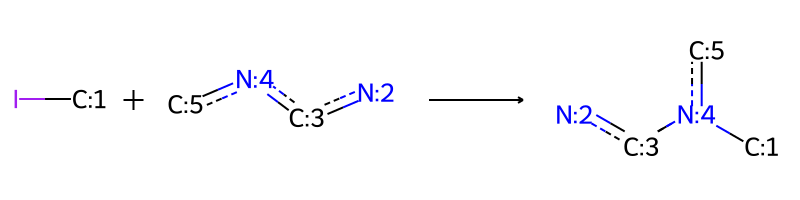

In [6]:
img = visualize_tpl(query_set["retro_template"][997])
img

In [8]:
retrieval_df[retrieval_df["query_ids"]==997]

,query_ids,selfsup_gallery_ids,supcon_namerxn_gallery_ids,supcon_hierar_gallery_ids
1497,997,"[3095, 3168, 1324, 4803, 799]","[1324, 3095, 3091, 1326, 3921]","[3329, 3323, 3321, 3325, 3324]"


#### self-sup

In [7]:
gallery_set[gallery_set.index.isin([3095, 3168, 1324, 4803, 799])]

,id,reactants>reagents>production,class,retro_template,superclass
799,206873,[CH3:1][n:2]1[cH:3][c:4]2[c:5]([CH2:6][OH:7])[...,179,([O;H0;D1;+0:1]=[CH;D2;+0:2]-[c:3])>>([OH;D1;+...,8
1324,287501,I[CH3:1].[nH:2]1[cH:3][c:4](-[c:5]2[cH:6][cH:7...,191,([CH3;D1;+0:1]-[n;H0;D3;+0:3](:[c:2]):[c:4])>>...,1
3095,260131,I[CH3:1].[nH:2]1[n:3][c:4]([I:5])[c:6]2[c:7]1[...,229,([#7;a:2]:[n;H0;D3;+0:3](-[CH3;D1;+0:1]):[c:4]...,1
3168,209803,Br[c:3]1[cH:4][cH:5][cH:6][cH:7][c:8]1-[n:9]1[...,65,([N;D1;H0:5]#[C;H0;D2;+0:4]-[c;H0;D3;+0:1](:[c...,9
4803,305107,Cl[c:3]1[n:4][c:5]([Cl:6])[n:7][cH:8][c:9]1[I:...,461,([#7;a:2]:[c;H0;D3;+0:1](-[O;H0;D2;+0:7]-[C;D1...,1


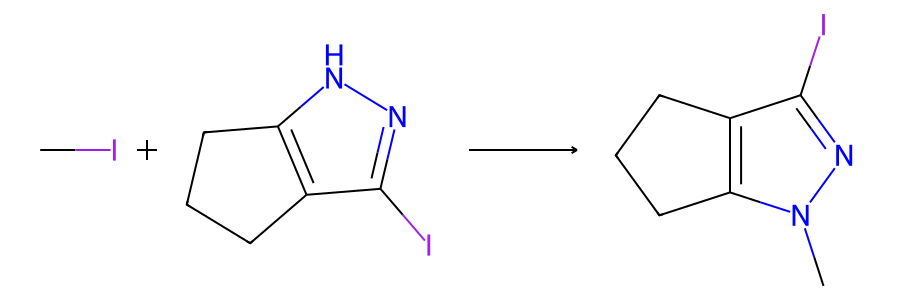

In [8]:
rxn_smiles = gallery_set["reactants>reagents>production"][3095]
rxn_smiles = ">>".join(clear_map_number(x) for x in rxn_smiles.split(">>"))
rxn = AllChem.ReactionFromSmarts(rxn_smiles,useSmiles=True)
d = Draw.MolDraw2DSVG(900, 300)
d.DrawReaction(rxn)
d.FinishDrawing()

svg = d.GetDrawingText()
svg2 = svg.replace('svg:','')
svg3 = SVG(svg2)
display(svg3)

#### supcon_namerxn

In [9]:
gallery_set[gallery_set.index.isin([1324, 3095, 3091, 1326, 3921])]

,id,reactants>reagents>production,class,retro_template,superclass
1324,287501,I[CH3:1].[nH:2]1[cH:3][c:4](-[c:5]2[cH:6][cH:7...,191,([CH3;D1;+0:1]-[n;H0;D3;+0:3](:[c:2]):[c:4])>>...,1
1326,112892,I[CH3:1].[nH:2]1[c:3]([Cl:4])[c:5]([CH:6]=[O:7...,191,([CH3;D1;+0:1]-[n;H0;D3;+0:3](:[c:2]):[c:4])>>...,1
3091,260272,I[CH3:1].[nH:2]1[n:3][c:4]([I:5])[c:6]2[cH:7][...,229,([#7;a:2]:[n;H0;D3;+0:3](-[CH3;D1;+0:1]):[c:4]...,1
3095,260131,I[CH3:1].[nH:2]1[n:3][c:4]([I:5])[c:6]2[c:7]1[...,229,([#7;a:2]:[n;H0;D3;+0:3](-[CH3;D1;+0:1]):[c:4]...,1
3921,323941,Cl[c:9]1[n:8][cH:7][c:6]2[cH:5][cH:4][cH:3][c:...,542,([#7;a:2]:[c;H0;D3;+0:1](:[#7;a:3])-[O;H0;D2;+...,1


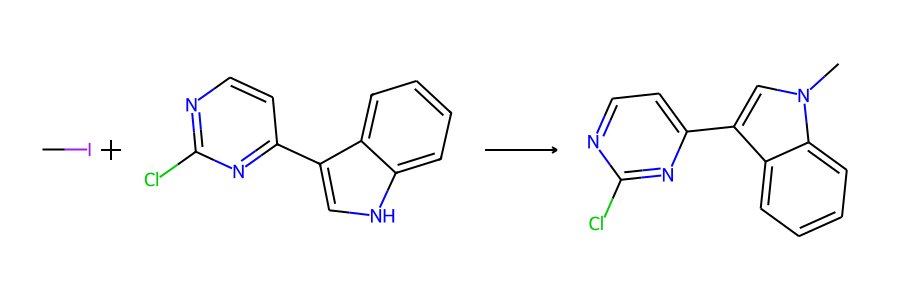

In [9]:
rxn_smiles = gallery_set["reactants>reagents>production"][1324]
rxn_smiles = ">>".join(clear_map_number(x) for x in rxn_smiles.split(">>"))
rxn = AllChem.ReactionFromSmarts(rxn_smiles,useSmiles=True)
d = Draw.MolDraw2DSVG(900, 300)
d.DrawReaction(rxn)
d.FinishDrawing()

svg = d.GetDrawingText()
svg2 = svg.replace('svg:','')
svg3 = SVG(svg2)
display(svg3)

#### hiclr

In [108]:
gallery_set[gallery_set.index.isin([3329, 3323, 3321, 3325, 3324])]

,id,reactants>reagents>production,class,retro_template,superclass
3321,70291,I[CH3:1].[nH:2]1[c:3]([C:4]([F:5])([F:6])[F:7]...,570,([#7;a:2]:[c:3]:[n;H0;D3;+0:4](-[CH3;D1;+0:1])...,1
3323,28803,I[CH3:1].[nH:2]1[c:3](=[O:4])[nH:5][cH:6][c:7]...,570,([#7;a:2]:[c:3]:[n;H0;D3;+0:4](-[CH3;D1;+0:1])...,1
3324,180324,I[CH3:1].[nH:2]1[cH:3][c:4](-[c:5]2[cH:6][cH:7...,570,([#7;a:2]:[c:3]:[n;H0;D3;+0:4](-[CH3;D1;+0:1])...,1
3325,73086,I[CH3:21].[CH3:1][c:2]1[cH:3][cH:4][c:5]2[c:6]...,570,([#7;a:2]:[c:3]:[n;H0;D3;+0:4](-[CH3;D1;+0:1])...,1
3329,388976,I[CH3:1].[nH:2]1[c:3](=[O:4])[cH:5][c:6]([Cl:7...,570,([#7;a:2]:[c:3]:[n;H0;D3;+0:4](-[CH3;D1;+0:1])...,1


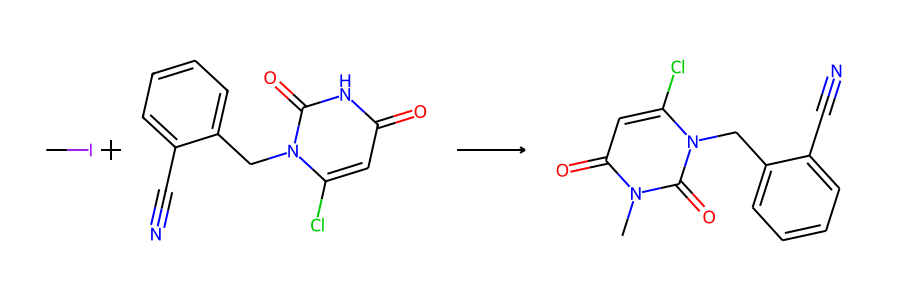

In [10]:
rxn_smiles = gallery_set["reactants>reagents>production"][3329]
rxn_smiles = ">>".join(clear_map_number(x) for x in rxn_smiles.split(">>"))
rxn = AllChem.ReactionFromSmarts(rxn_smiles,useSmiles=True)
d = Draw.MolDraw2DSVG(900, 300)
d.DrawReaction(rxn)
d.FinishDrawing()

svg = d.GetDrawingText()
svg2 = svg.replace('svg:','')
svg3 = SVG(svg2)
display(svg3)